In [1]:
# Instalando bibliotecas
!pip install pandas numpy matplotlib seaborn yfinance PyPortfolioOpt

In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import HRPOpt
from pypfopt import expected_returns, risk_models

In [3]:
# Função para plotar gráficos de rosca
def plot_donut_chart(ax, weights, title):
    weights = {k: v for k, v in weights.items() if v != 0}
    ax.pie(weights.values(), labels=weights.keys(), autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))
    # Desenhar um círculo no centro para transformá-lo em um gráfico de rosca
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    ax.axis('equal')
    ax.set_title(title)

In [4]:
inicio = dt.date(2015, 1, 1)
final = dt.date(2022, 12, 31)
final_val = dt.date(2023, 8, 31)

# Baixando e Analisando os Dados

In [5]:
lista_acoes = ["WEGE3", "LREN3", "VALE3", "PETR4", "ITSA4", "KLBN4"]
lista_acoes = [acao + ".SA" for acao in lista_acoes]
#lista_acoes = ["AAPL", "NKE", "GOOGL", "AMZN"]

precos = yf.download(lista_acoes, start=inicio, end=final)['Adj Close']
precos

[*********************100%%**********************]  6 of 6 completed


,ITSA4.SA,KLBN4.SA,LREN3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,,,
2015-01-02,3.502200,1.531267,10.610880,3.318810,12.725252,5.088045
2015-01-05,3.513659,1.531267,10.315900,3.035151,12.533895,5.122736
2015-01-06,3.540394,1.531267,10.434731,2.935870,13.036207,5.046746
2015-01-07,3.674065,1.531267,10.612278,3.074155,13.514599,4.988928
2015-01-08,3.712256,1.531267,10.624855,3.272715,13.658119,5.073178
...,...,...,...,...,...,...
2022-12-23,8.179767,3.702040,21.468344,20.212734,81.991486,37.959820
2022-12-26,8.074897,3.673342,20.320356,20.067896,82.741867,37.654171
2022-12-27,7.989096,3.749870,19.996565,20.204685,84.717575,37.476692


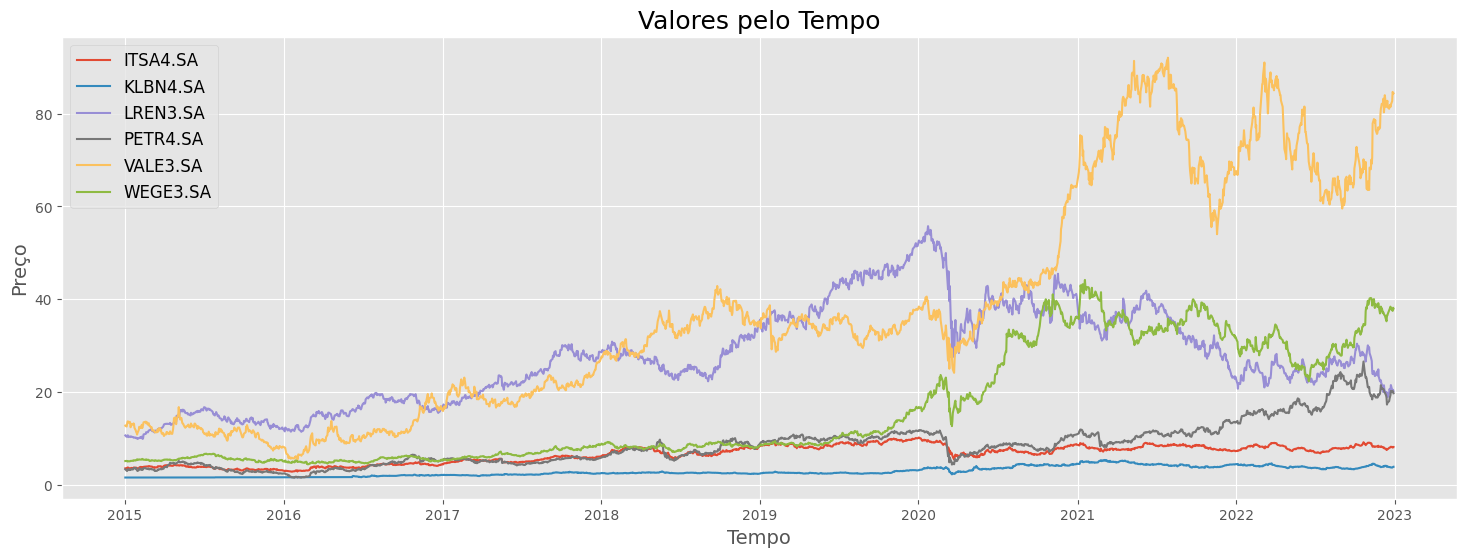

In [6]:
plt.figure(figsize=(18,6))
for nome_coluna, serie in precos.items():
  plt.plot(serie, label=nome_coluna)
plt.legend(fontsize=12)
plt.title("Valores pelo Tempo", fontsize=18)
plt.xlabel("Tempo", fontsize=14)
plt.ylabel("Preço", fontsize=14)
plt.show()

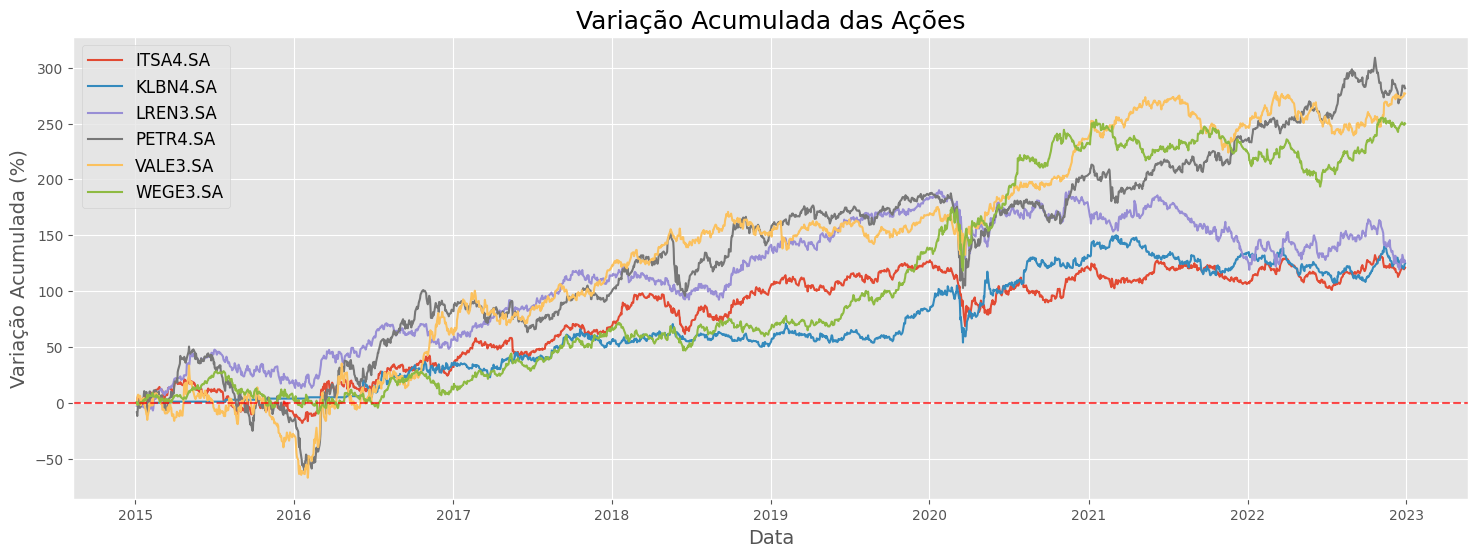

In [7]:
# Calcula as variações diárias (retornos diários)
returns = precos.iloc[:, 0:].pct_change()
# Calcula a variação acumulada
cumulative_returns = returns.cumsum()*100

# Plota a variação acumulada das ações
plt.figure(figsize=(18, 6))
for coluna in cumulative_returns.columns:
    plt.plot(cumulative_returns[coluna], label=coluna)
plt.axhline(0, color="red", alpha=0.7, linestyle="--")

plt.xlabel('Data', fontsize=14)
plt.ylabel('Variação Acumulada (%)', fontsize=14)
plt.title('Variação Acumulada das Ações', fontsize=18)
plt.legend(fontsize=12)
plt.show()

# Otimização de Portfolio

In [8]:
# Suponha que você já tenha um DataFrame pandas chamado 'df' com os preços de fechamento das ações.
df = precos.copy()

# Calcular os retornos diários a partir dos preços de fechamento
returns = df.pct_change()

# Calcular as médias dos retornos esperados
mu = expected_returns.mean_historical_return(df)
# Calcular a matriz de covariância dos retornos
S = risk_models.sample_cov(df)

# Método de Markowitz
ef = EfficientFrontier(mu, S)
weights_markowitz = ef.max_sharpe()

# Hierarchical Risk Parity (HRP)
hrp = HRPOpt(returns)
weights_hrp = hrp.optimize()


In [9]:
for az in ef.portfolio_performance(verbose=True)[:0]:
  print(az)

Expected annual return: 27.0%
Annual volatility: 29.1%
Sharpe Ratio: 0.86


In [10]:
for az in hrp.portfolio_performance(verbose=True)[:0]:
  print(az)

Expected annual return: 21.9%
Annual volatility: 23.1%
Sharpe Ratio: 0.86


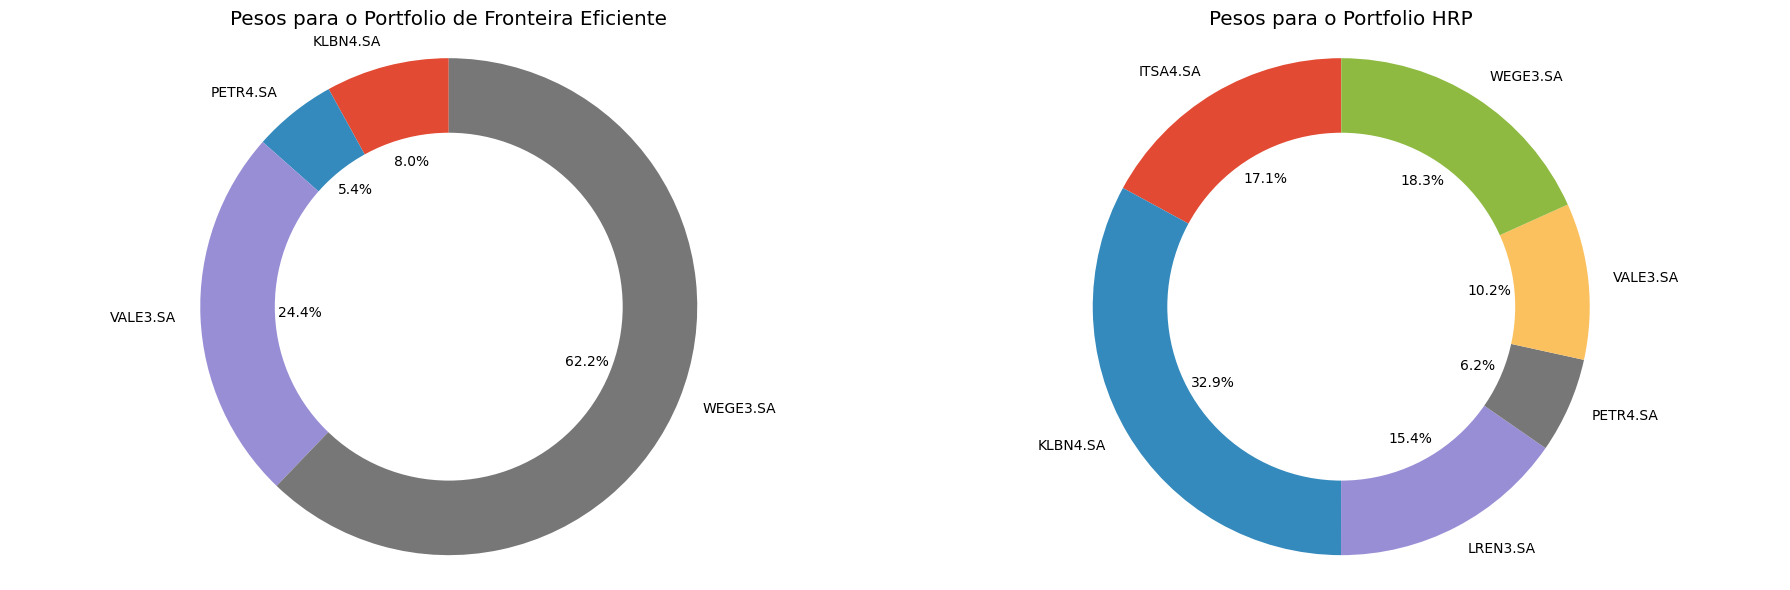

In [11]:
# Criar uma figura com dois subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotar os gráficos de rosca lado a lado
plot_donut_chart(axes[0], weights_markowitz, "Pesos para o Portfolio de Fronteira Eficiente")
plot_donut_chart(axes[1], weights_hrp, "Pesos para o Portfolio HRP")

# Ajustar o espaçamento entre os subplots
plt.tight_layout()

# Exibir a figura
plt.show()

In [12]:
# Filtrar apenas ações com alocação diferente de 0%
non_zero_weights_markowitz = {k: v for k, v in weights_markowitz.items() if v != 0}
non_zero_weights_hrp = {k: v for k, v in weights_hrp.items() if v != 0}

In [13]:
# Calcular as métricas de risco (VaR e CVaR) para o portfólio de Markowitz
portfolio_returns_markowitz = df[list(non_zero_weights_markowitz.keys())].pct_change().dropna()
portfolio_weights_markowitz = list(non_zero_weights_markowitz.values())
portfolio_returns_markowitz = (portfolio_returns_markowitz * portfolio_weights_markowitz).sum(axis=1)
portfolio_var_markowitz = portfolio_returns_markowitz.quantile(0.05)
portfolio_cvar_markowitz = portfolio_returns_markowitz[portfolio_returns_markowitz <= portfolio_var_markowitz].mean()

# Calcular as métricas de risco (VaR e CVaR) para o portfólio HRP
portfolio_returns_hrp = df[list(non_zero_weights_hrp.keys())].pct_change().dropna()
portfolio_weights_hrp = list(non_zero_weights_hrp.values())
portfolio_returns_hrp = (portfolio_returns_hrp * portfolio_weights_hrp).sum(axis=1)
portfolio_var_hrp = portfolio_returns_hrp.quantile(0.05)
portfolio_cvar_hrp = portfolio_returns_hrp[portfolio_returns_hrp <= portfolio_var_hrp].mean()

# Exibir os resultados
print("VaR e CVaR para o portfólio de Markowitz:")
print(f"VaR (5%): {portfolio_var_markowitz:.4f}")
print(f"CVaR (5%): {portfolio_cvar_markowitz:.4f}")

print("\nVaR e CVaR para o portfólio HRP:")
print(f"VaR (5%): {portfolio_var_hrp:.4f}")
print(f"CVaR (5%): {portfolio_cvar_hrp:.4f}")

VaR e CVaR para o portfólio de Markowitz:
VaR (5%): -0.0254
CVaR (5%): -0.0388

VaR e CVaR para o portfólio HRP:
VaR (5%): -0.0204
CVaR (5%): -0.0309


**Para o portfólio de Markowitz:**

VaR (Value at Risk) a 5%: -0.0223
Isso significa que, com 95% de confiança, a perda máxima esperada para o portfólio de Markowitz não deve exceder -0.0223, o que pode ser interpretado como uma perda de 2,23% do valor do portfólio.
CVaR (Conditional Value at Risk) a 5%: -0.0335
Isso indica que, caso as perdas excedam o VaR de -0.0223, a média das perdas adicionais será de -0.0335, ou seja, 3,35% do valor do portfólio. Portanto, em cenários de perdas extremas além do VaR, a média das perdas adicionais é de 3,35%.


**Para o portfólio HRP:**

VaR (Value at Risk) a 5%: -0.0205
Com 95% de confiança, a perda máxima esperada para o portfólio HRP não deve exceder -0.0205, o que pode ser interpretado como uma perda de 2,05% do valor do portfólio.
CVaR (Conditional Value at Risk) a 5%: -0.0318
Se as perdas ultrapassarem o VaR de -0.0205, a média das perdas adicionais será de -0.0318, ou seja, 3,18% do valor do portfólio. Portanto, em cenários de perdas extremas além do VaR, a média das perdas adicionais é de 3,18%.

# Validando

In [14]:
def avalia_retornos(alocacao_ativos, acoes_validacao):
  # Calcule os retornos diários dos ativos no DataFrame
  retornos_diarios = acoes_validacao.pct_change()

  # Calcule o retorno diário da carteira
  retorno_carteira_diario = (retornos_diarios * pd.Series(alocacao_ativos)).sum(axis=1)

  # Calcule o retorno acumulado da carteira
  retorno_acumulado_carteira = retorno_carteira_diario.cumsum()*100

  return retorno_acumulado_carteira

In [15]:
# Crie um objeto ticker para o ETF desejado
etf_symbol = ["SPY", "BOVA11.SA"]

etfs = yf.download(etf_symbol, start=final, end=final_val)['Adj Close']
acoes_validacao = yf.download(lista_acoes, start=final, end=final_val)['Adj Close']


[*********************100%%**********************]  2 of 2 completed
[*********************100%%**********************]  6 of 6 completed


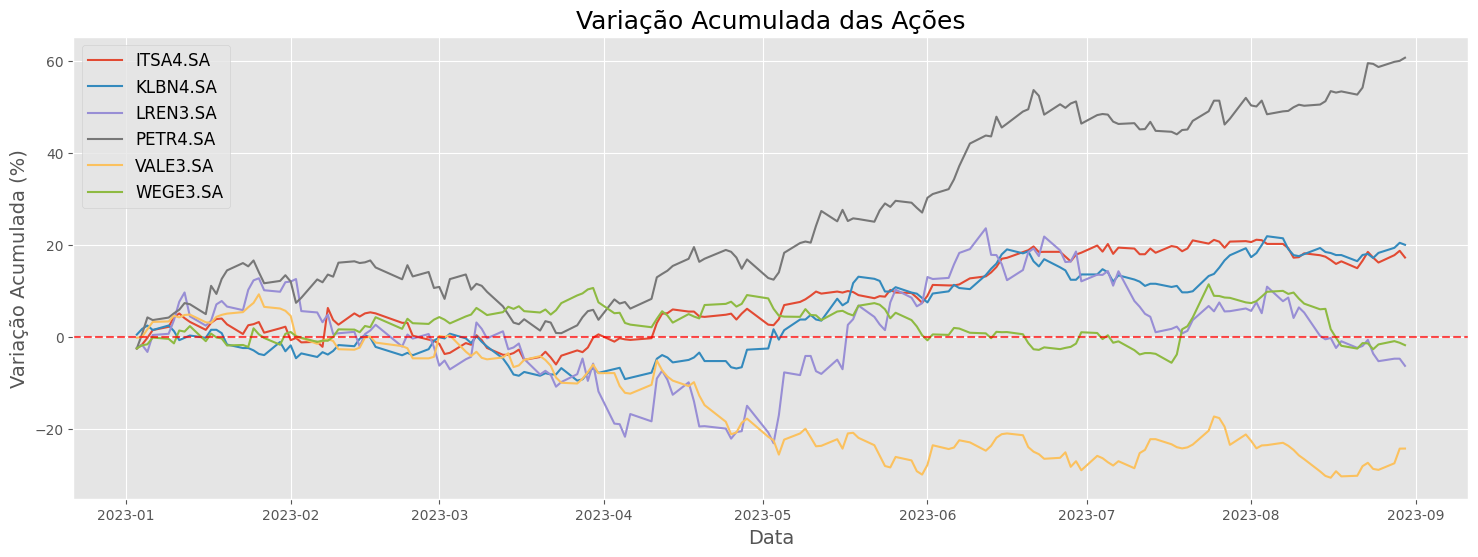

In [16]:
# Calcula as variações diárias (retornos diários)
returns = acoes_validacao.iloc[:, 0:].pct_change()
# Calcula a variação acumulada
cumulative_returns = returns.cumsum()*100

# Plota a variação acumulada das ações
plt.figure(figsize=(18, 6))
for coluna in cumulative_returns.columns:
    plt.plot(cumulative_returns[coluna], label=coluna)
plt.axhline(0, color="red", alpha=0.7, linestyle="--")

plt.xlabel('Data', fontsize=14)
plt.ylabel('Variação Acumulada (%)', fontsize=14)
plt.title('Variação Acumulada das Ações', fontsize=18)
plt.legend(fontsize=12)
plt.show()

In [17]:
retornos_markowitz = avalia_retornos(non_zero_weights_markowitz, acoes_validacao)
retornos_hrp = avalia_retornos(non_zero_weights_hrp, acoes_validacao)

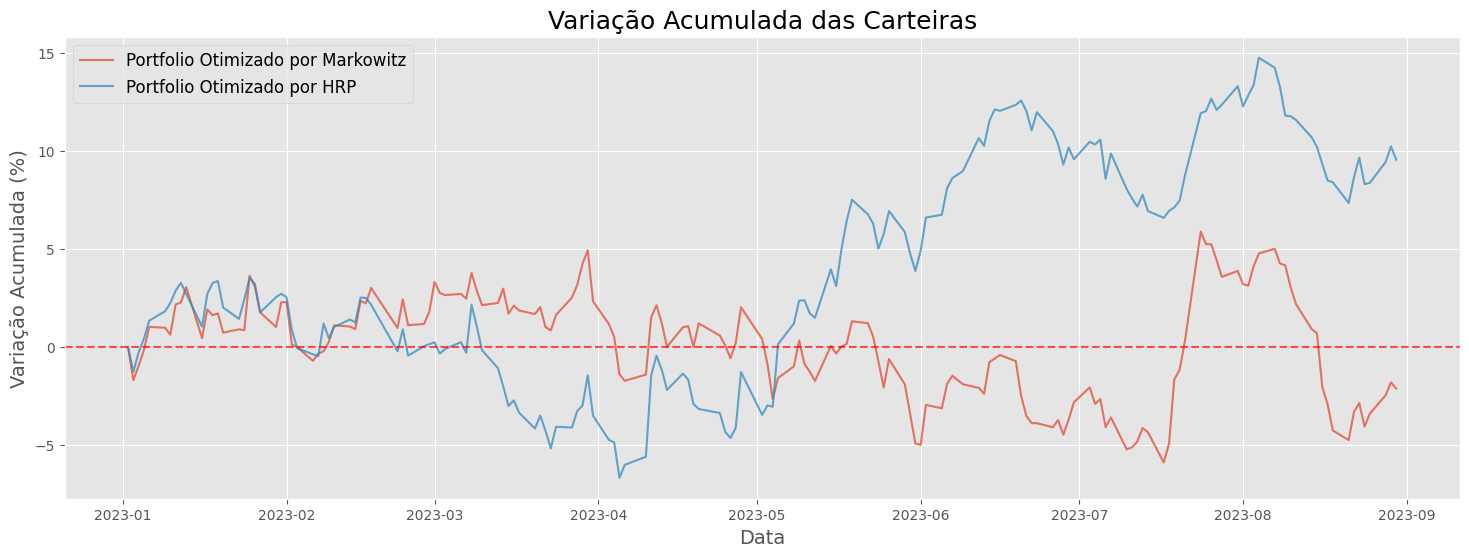

In [18]:
# Plota a variação acumulada das carteiras
plt.figure(figsize=(18, 6))

plt.plot(retornos_markowitz, label="Portfolio Otimizado por Markowitz", alpha=0.75)
plt.plot(retornos_hrp, label="Portfolio Otimizado por HRP", alpha=0.75)
plt.axhline(0, color="red", alpha=0.7, linestyle="--")

plt.xlabel('Data', fontsize=14)
plt.ylabel('Variação Acumulada (%)', fontsize=14)
plt.title('Variação Acumulada das Carteiras', fontsize=18)
plt.legend(fontsize=12)
plt.show()

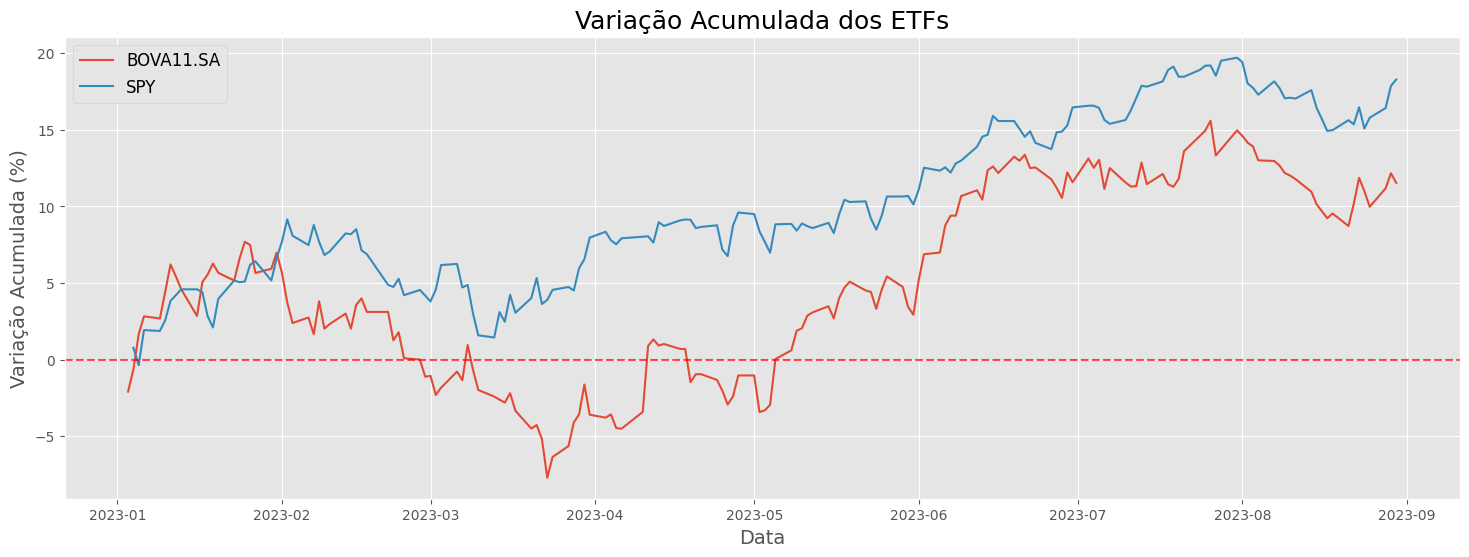

In [20]:
# Calcula as variações diárias (retornos diários)
returns = etfs.iloc[:, 0:].pct_change()
# Calcula a variação acumulada
cumulative_returns = returns.cumsum()*100

# Plota a variação acumulada das ações
plt.figure(figsize=(18, 6))
for coluna in cumulative_returns.columns:
    plt.plot(cumulative_returns[coluna], label=coluna)
plt.axhline(0, color="red", alpha=0.7, linestyle="--")

plt.xlabel('Data', fontsize=14)
plt.ylabel('Variação Acumulada (%)', fontsize=14)
plt.title('Variação Acumulada dos ETFs', fontsize=18)
plt.legend(fontsize=12)
plt.show()

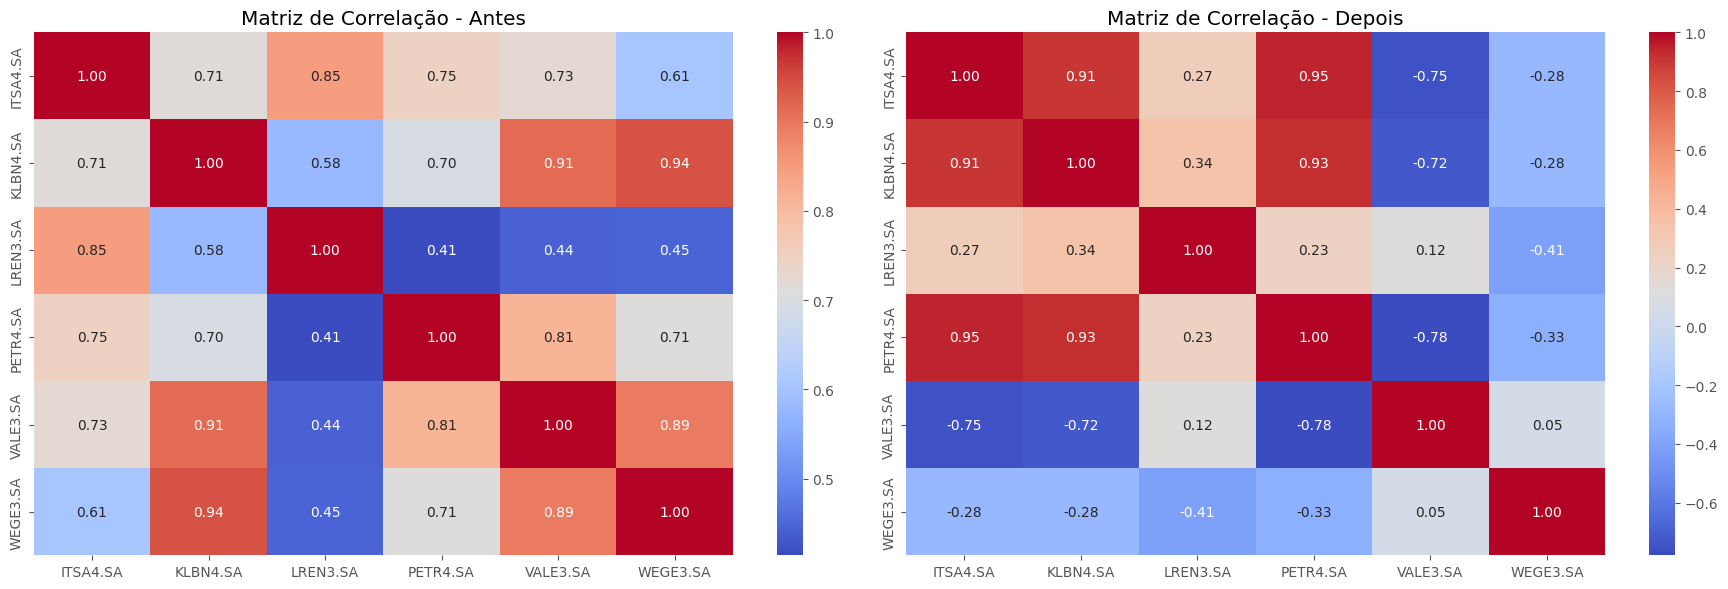

In [30]:
# Calcule a matriz de correlação
correlation_matrix_antes = precos.corr()
correlation_matrix_depois = acoes_validacao.corr()

plt.figure(figsize=(18,6))

plt.subplot(1, 2, 1)

# Plote um mapa de calor da matriz de correlação
sns.heatmap(correlation_matrix_antes, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação - Antes')

plt.subplot(1, 2, 2)

# Plote um mapa de calor da matriz de correlação
sns.heatmap(correlation_matrix_depois, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação - Depois')

plt.tight_layout()
plt.show()